**参考：**  
https://www.kaggle.com/elenapetrova/time-series-analysis-and-forecasts-with-prophet  
https://www.kaggle.com/danspace/rossmann-store-sales-xgboost/notebook

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
df_train = pd.read_csv('train.csv',parse_dates = True, low_memory = False)
df_test = pd.read_csv('test.csv',parse_dates = True, low_memory = False)

In [5]:
store = pd.read_csv('store.csv',low_memory = False)

In [6]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### 探索数据 

- 探索数据集**train.csv**

In [7]:
df_train.shape

(1017209, 9)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


**Short description:**  
- Sales: the turnover for any given day (target variable).  
- Customers: the number of customers on a given day.  
- Open: an indicator for whether the store was open: 0 = closed, 1 = open.  
- Promo: indicates whether a store is running a promo on that day.  
- StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays.  
- SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools.

增加新的变量

In [9]:
df_train[['year','month','day']]=df_train.Date.str.split('-',expand=True).apply(pd.to_numeric)
df_train['SalePerCustomer'] = df_train['Sales']/df_train['Customers']
df_train['WeekofYear']=pd.to_datetime(df_train['Date']).dt.weekofyear
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,day,SalePerCustomer,WeekofYear
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,9.482883,31
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,9.702400,31
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,10.126675,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31,9.342457,31
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,8.626118,31


In [10]:
df_train[['Sales','SalePerCustomer']].describe()

,Sales,SalePerCustomer
count,1.017209e+06,844340.000000
mean,5.773819e+03,9.493619
std,3.849926e+03,2.197494
min,0.000000e+00,0.000000
25%,3.727000e+03,7.895563
50%,5.744000e+03,9.250000
75%,7.856000e+03,10.899729
max,4.155100e+04,64.957854


In [11]:
df_train['Date']=pd.to_datetime(df_train['Date'])

In [13]:
store_23 = df_train[df_train.Store==23].sort_values(by='Date',axis=0,ascending=True)
store_189= df_train[df_train.Store==189].sort_values(by='Date',axis=0,ascending=True)

In [19]:
store_23 = store_23[store_23.Sales > 0]
store_189 = store_189[store_189.Sales > 0]

Text(0,0.5,'Sales of Store_189')

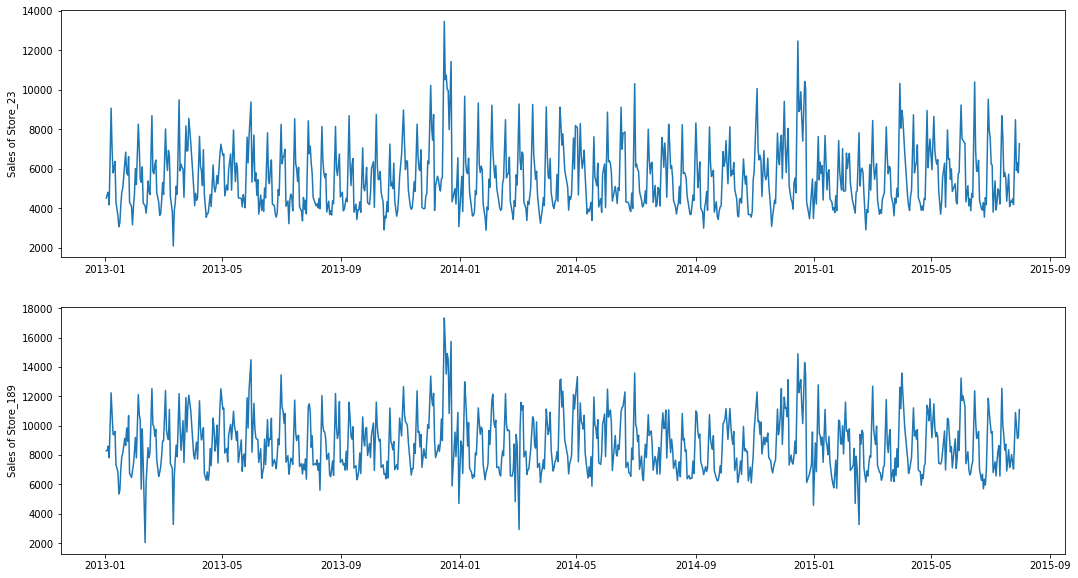

In [20]:
f = plt.figure(figsize=(18,10))
ax1 = f.add_subplot(211)
ax1.plot(store_23['Date'],store_23['Sales'])
ax1.set_ylabel('Sales of Store_23')


ax2 = f.add_subplot(212)
ax2.plot(store_189['Date'],store_189['Sales'])
ax2.set_ylabel('Sales of Store_189')

简览随机两个store的销售趋势，在2013年-2015年的三年间的波动趋势基本保持一致，而且明显在12月圣诞节附近有较大的增加，推测销售与节假日有较大关系。

ECDF: empirical cumulative distribution function

In [21]:
from statsmodels.distributions.empirical_distribution import ECDF

In [22]:
cdf=ECDF(df_train['Sales'])

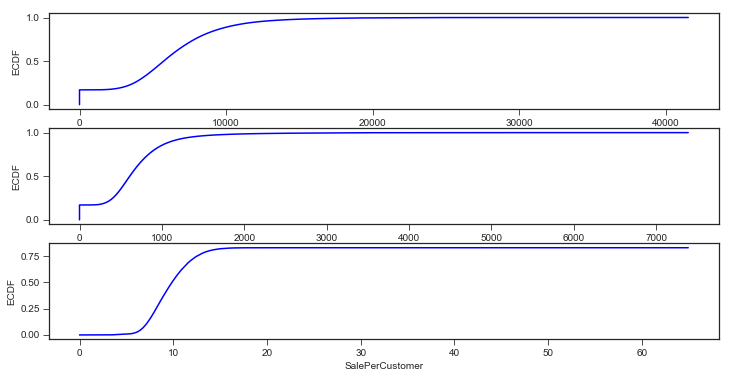

In [23]:
#sns.set(style='ticks')
sns.set_style('ticks')
plt.figure(figsize=(12,6))

plt.subplot(311)
cdf=ECDF(df_train['Sales'])
plt.plot(cdf.x,cdf.y,label = 'statsmodels',color='b')
plt.xlabel('Sales')
plt.ylabel('ECDF');

plt.subplot(312)
cdf=ECDF(df_train['Customers'])
plt.plot(cdf.x,cdf.y,label='statsmodels',color='b')
plt.xlabel('Customers')
plt.ylabel('ECDF');

plt.subplot(313)
cdf=ECDF(df_train['SalePerCustomer'])
plt.plot(cdf.x,cdf.y,label='statsmodels',color='b')
plt.xlabel('SalePerCustomer')
plt.ylabel('ECDF');

In [24]:
df_train[df_train['Sales']==0].count()[0]/df_train.count()[0]

0.16994639253093513

有17%数据是药店无客户无收入的状态，进一步确认这些是否均为不开业导致。

In [25]:
df_train[df_train['Open']==0].count()[0]/df_train.count()[0]

0.16989330609540418

药店不开业占数据占比为16.99%

In [26]:
df_train[(df_train['Open']==1) & (df_train['Sales']==0)].head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,day,SalePerCustomer,WeekofYear
86825,971,5,2015-05-15,0,0,1,0,0,1,2015,5,15,NaN,20
142278,674,4,2015-03-26,0,0,1,0,0,0,2015,3,26,NaN,13
196938,699,4,2015-02-05,0,0,1,1,0,0,2015,2,5,NaN,6
322053,708,3,2014-10-01,0,0,1,1,0,0,2014,10,1,NaN,40
330176,357,1,2014-09-22,0,0,1,0,0,0,2014,9,22,NaN,39


- 合并探索数据集**store.csv**

**Short description:** 

- Store: a unique Id for each store
- StoreType: differentiates between 4 different store models: a, b, c, d
- Assortment: describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance: distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year]: gives the approximate year and month of the time the nearest competitor was opened
- Promo2: Promo2 is a continuing a promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week]: describes the year and calendar week when the store started participating in Promo2
- PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [27]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [28]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [29]:
train_df=pd.merge(df_train,store,on='Store',how='left')

In [30]:
train_df.groupby('StoreType')['Sales','Customers'].sum()

,Sales,Customers
StoreType,,
a,3165334859,363541434
b,159231395,31465621
c,783221426,92129705
d,1765392943,156904995


In [31]:
train_df.groupby('StoreType')['SalePerCustomer'].mean()

StoreType
a     8.846277
b     5.133097
c     8.626227
d    11.277862
Name: SalePerCustomer, dtype: float64

In [32]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,...,WeekofYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,...,31,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,...,31,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,...,31,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,...,31,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,...,31,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


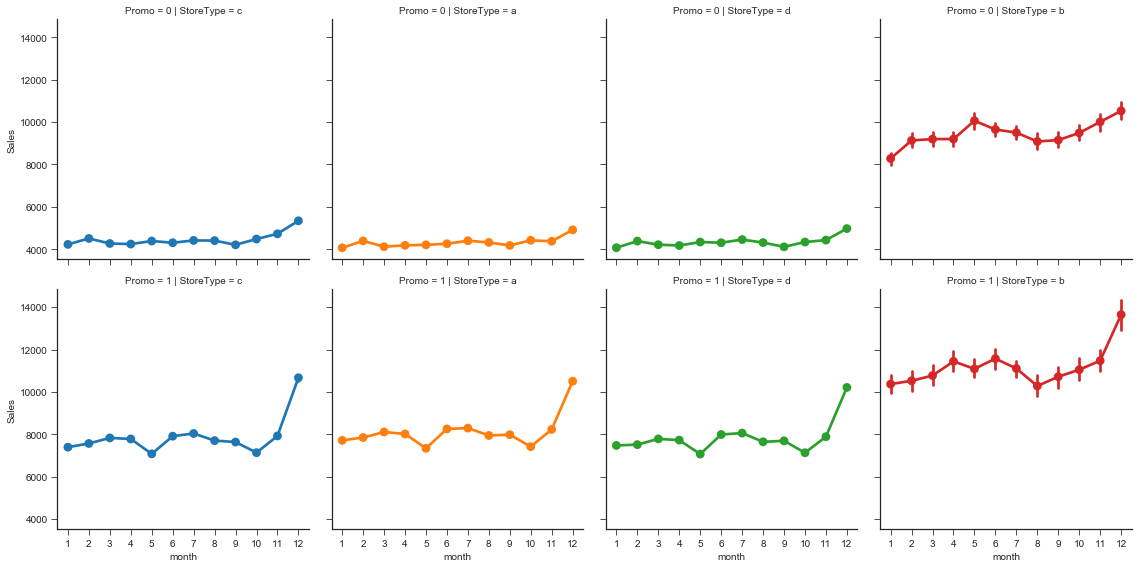

In [33]:
#sns.set(style="ticks")
sns.factorplot(x="month", y="Sales", data=train_df,
              col ='StoreType',
              row='Promo',
              hue='StoreType'
              );

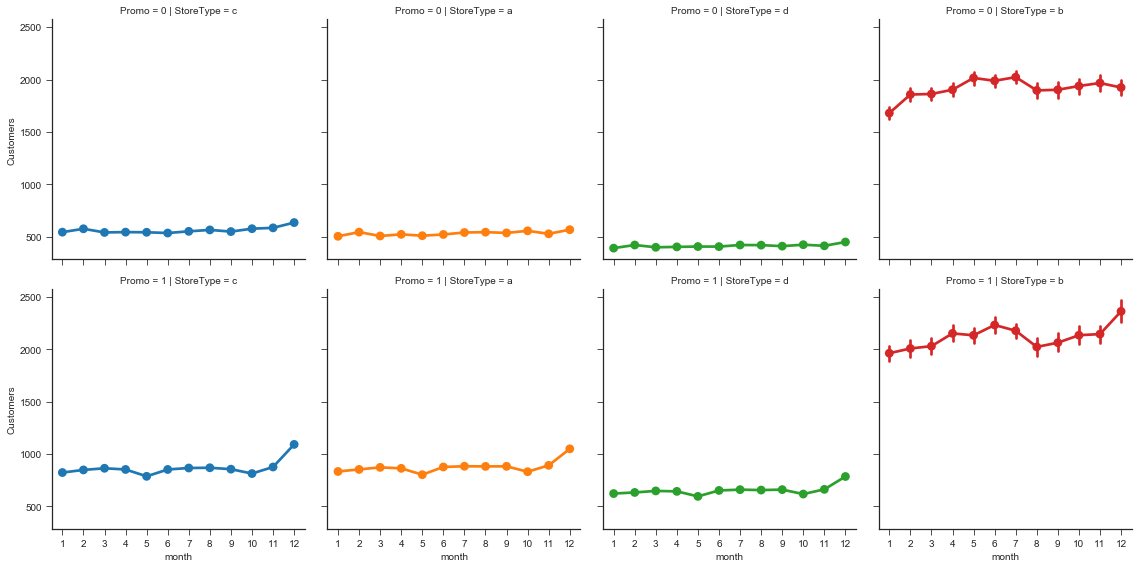

In [34]:
sns.factorplot(x="month", y="Customers", data=train_df,
              col ='StoreType',
              row='Promo',
              hue='StoreType'
              );

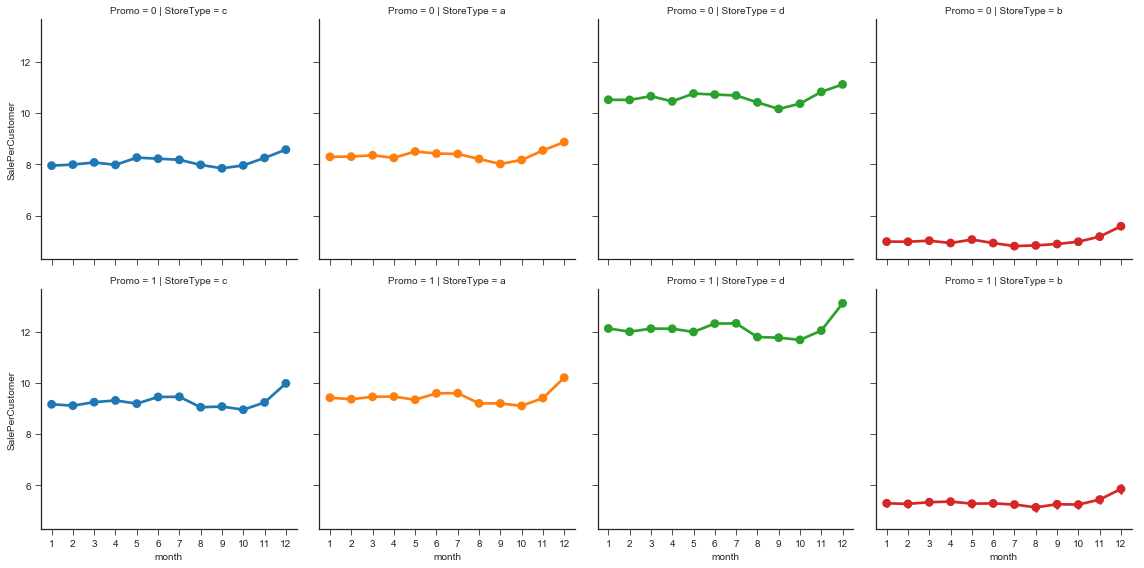

In [35]:
sns.factorplot(x="month", y="SalePerCustomer", data=train_df,
              col ='StoreType',
              row='Promo',
              hue='StoreType'
              );

基本销售趋势均保持一直，但是是否有促销以及药店类型对实际销售规模有较大的影响。当促销存在时，整体客户数以及销售额较平时有较大的增加；同时，对于类型为b的药店，销售额和客户量都明显高于其他类型的药店，但实际上每个客户的销售支出相对于其他药店而言，更小，推测b类型的药店主打的是小品类的商品。

### 处理数据集

1. 当前日期与竞争对手开业时间的时间差；
2. 当前日期与Promo2进行的时间差；
3. 当前的月份是否是促销月份；
4. 用0填充缺失值；
5. 将分类变量转换成数字变量；
6. 只用open = 1 且 sales > 0的train数据集作为训练数据集。

In [36]:
def data_EDA(data):
    data[['year','month','day']]=data.Date.str.split('-',expand=True).apply(pd.to_numeric)
    data['WeekofYear']=pd.to_datetime(data['Date']).dt.weekofyear
    
    data['CompetitionOpen']=12*(data.year-data.CompetitionOpenSinceYear)+(data.month-data.CompetitionOpenSinceMonth)
    data['CompetitionOpen'] = data['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)
    
    data['Promo2Open']=12*(data.year-data.Promo2SinceYear)+(data.WeekofYear-data.Promo2SinceWeek)/4.0
    data['Promo2Open'] = data['Promo2Open'].apply(lambda x: x if x > 0 else 0)
    
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    trans={'0':0,'a':1,'b':2,'c':3,'d':4}
    
    data['monthStr'] = data.month.map(month2str)

    data['StoreType']=data.StoreType.map(trans)
    data['Assortment']=data.Assortment.map(trans)
    data['StateHoliday']=data.StateHoliday.map(trans)
    
    data.fillna(0, inplace=True)
    data.loc[data.PromoInterval==0,'PromoInterval']=''
    data['IsPromoMonth']=0
    for item in data.PromoInterval.unique():
        if item !='':
            for month in item.split(','):
                data.loc[(data.monthStr == month)&(data.PromoInterval == item),'IsPromoMonth' ]=1
    return data

In [37]:
df_train = pd.read_csv('train.csv',parse_dates = True, low_memory = False)
df_test = pd.read_csv('test.csv')
store = pd.read_csv('store.csv',low_memory = False)

# fill missing values in test with 1
df_test.fillna(value = 1, inplace = True)

train = pd.merge(df_train,store,on='Store',how='left')
test = pd.merge(df_test,store,on='Store',how='left')

In [38]:
train = train[(train.Open==1) & (train.Sales > 0)]
train = data_EDA(train)
test = data_EDA(test)

### 建立预测模型

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
import xgboost as xgb

In [41]:
features=['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'year', 'month', 'day',
       'WeekofYear', 'CompetitionOpen', 'Promo2Open', 'IsPromoMonth']  

In [57]:
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.04,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 13
          }
num_boost_round = 2500

In [44]:
X_train, X_valid = train_test_split(train, test_size=0.012, random_state=10)
y_train = np.log1p(X_train.Sales)
y_valid = np.log1p(X_valid.Sales)
y_total = np.log1p(train.Sales)
dtrain = xgb.DMatrix(X_train[features], y_train)
dvalid = xgb.DMatrix(X_valid[features], y_valid)
dtrain_total = xgb.DMatrix(train[features],y_total)

In [45]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

In [46]:
def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y, yhat)

In [47]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

In [58]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist,
                early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

[0]	train-rmse:7.93858	eval-rmse:7.93689	train-rmspe:0.999778	eval-rmspe:0.999778
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.62167	eval-rmse:7.61999	train-rmspe:0.999632	eval-rmspe:0.999632
[2]	train-rmse:7.31743	eval-rmse:7.31581	train-rmspe:0.999442	eval-rmspe:0.999442
[3]	train-rmse:7.02541	eval-rmse:7.02376	train-rmspe:0.999196	eval-rmspe:0.999196
[4]	train-rmse:6.74513	eval-rmse:6.74347	train-rmspe:0.998881	eval-rmspe:0.998881
[5]	train-rmse:6.476	eval-rmse:6.47436	train-rmspe:0.998486	eval-rmspe:0.998486
[6]	train-rmse:6.21767	eval-rmse:6.21601	train-rmspe:0.997993	eval-rmspe:0.997993
[7]	train-rmse:5.96976	eval-rmse:5.96804	train-rmspe:0.997384	eval-rmspe:0.997384
[8]	train-rmse:5.73169	eval-rmse:5.72994	train-rmspe:0.996641	eval-rmspe:0.99664
[9]	train-rmse:5.50319	eval-rmse:5.50142	train-rmspe:0.995742	eval-rmspe:0.99574
[10]	train-rmse:5.28382	eval-rmse:5.28

[97]	train-rmse:0.279952	eval-rmse:0.27996	train-rmspe:0.277845	eval-rmspe:0.250595
[98]	train-rmse:0.275544	eval-rmse:0.275543	train-rmspe:0.276178	eval-rmspe:0.248373
[99]	train-rmse:0.271665	eval-rmse:0.271783	train-rmspe:0.274673	eval-rmspe:0.246432
[100]	train-rmse:0.268304	eval-rmse:0.268464	train-rmspe:0.273681	eval-rmspe:0.24494
[101]	train-rmse:0.264642	eval-rmse:0.264863	train-rmspe:0.272447	eval-rmspe:0.243266
[102]	train-rmse:0.261939	eval-rmse:0.26225	train-rmspe:0.271891	eval-rmspe:0.242391
[103]	train-rmse:0.257525	eval-rmse:0.257876	train-rmspe:0.269762	eval-rmspe:0.239904
[104]	train-rmse:0.255031	eval-rmse:0.255432	train-rmspe:0.269089	eval-rmspe:0.239079
[105]	train-rmse:0.252141	eval-rmse:0.252566	train-rmspe:0.268213	eval-rmspe:0.237882
[106]	train-rmse:0.249229	eval-rmse:0.249745	train-rmspe:0.267233	eval-rmspe:0.236701
[107]	train-rmse:0.246992	eval-rmse:0.247623	train-rmspe:0.265444	eval-rmspe:0.236049
[108]	train-rmse:0.2451	eval-rmse:0.245785	train-rmspe:0.265

[193]	train-rmse:0.167659	eval-rmse:0.170115	train-rmspe:0.217246	eval-rmspe:0.187933
[194]	train-rmse:0.16742	eval-rmse:0.169899	train-rmspe:0.217062	eval-rmspe:0.187792
[195]	train-rmse:0.166713	eval-rmse:0.169207	train-rmspe:0.216496	eval-rmspe:0.187118
[196]	train-rmse:0.166246	eval-rmse:0.16876	train-rmspe:0.216131	eval-rmspe:0.18673
[197]	train-rmse:0.166012	eval-rmse:0.16853	train-rmspe:0.215835	eval-rmspe:0.186535
[198]	train-rmse:0.165883	eval-rmse:0.168373	train-rmspe:0.215656	eval-rmspe:0.186364
[199]	train-rmse:0.165372	eval-rmse:0.167881	train-rmspe:0.215196	eval-rmspe:0.185861
[200]	train-rmse:0.164966	eval-rmse:0.1675	train-rmspe:0.214842	eval-rmspe:0.18551
[201]	train-rmse:0.164777	eval-rmse:0.16734	train-rmspe:0.214677	eval-rmspe:0.185412
[202]	train-rmse:0.164238	eval-rmse:0.166819	train-rmspe:0.214229	eval-rmspe:0.184943
[203]	train-rmse:0.163931	eval-rmse:0.166518	train-rmspe:0.213982	eval-rmspe:0.184669
[204]	train-rmse:0.163178	eval-rmse:0.165793	train-rmspe:0.213

[289]	train-rmse:0.135731	eval-rmse:0.138825	train-rmspe:0.18024	eval-rmspe:0.156756
[290]	train-rmse:0.135504	eval-rmse:0.138619	train-rmspe:0.180051	eval-rmspe:0.15656
[291]	train-rmse:0.135334	eval-rmse:0.138477	train-rmspe:0.179907	eval-rmspe:0.156402
[292]	train-rmse:0.135011	eval-rmse:0.138174	train-rmspe:0.179598	eval-rmspe:0.156109
[293]	train-rmse:0.134856	eval-rmse:0.138055	train-rmspe:0.179469	eval-rmspe:0.156005
[294]	train-rmse:0.134421	eval-rmse:0.137654	train-rmspe:0.178995	eval-rmspe:0.15561
[295]	train-rmse:0.134189	eval-rmse:0.137441	train-rmspe:0.178769	eval-rmspe:0.155381
[296]	train-rmse:0.134092	eval-rmse:0.137346	train-rmspe:0.178564	eval-rmspe:0.155274
[297]	train-rmse:0.133838	eval-rmse:0.137093	train-rmspe:0.178332	eval-rmspe:0.154911
[298]	train-rmse:0.133652	eval-rmse:0.136897	train-rmspe:0.17818	eval-rmspe:0.154716
[299]	train-rmse:0.133442	eval-rmse:0.136719	train-rmspe:0.177995	eval-rmspe:0.154593
[300]	train-rmse:0.133263	eval-rmse:0.136539	train-rmspe:0

[385]	train-rmse:0.118499	eval-rmse:0.122595	train-rmspe:0.152735	eval-rmspe:0.1401
[386]	train-rmse:0.118282	eval-rmse:0.122379	train-rmspe:0.152555	eval-rmspe:0.13991
[387]	train-rmse:0.118149	eval-rmse:0.122252	train-rmspe:0.151891	eval-rmspe:0.139771
[388]	train-rmse:0.117957	eval-rmse:0.122097	train-rmspe:0.151709	eval-rmspe:0.139617
[389]	train-rmse:0.117826	eval-rmse:0.122001	train-rmspe:0.151563	eval-rmspe:0.139546
[390]	train-rmse:0.11767	eval-rmse:0.121853	train-rmspe:0.151394	eval-rmspe:0.139379
[391]	train-rmse:0.117575	eval-rmse:0.121764	train-rmspe:0.151288	eval-rmspe:0.139278
[392]	train-rmse:0.117408	eval-rmse:0.121608	train-rmspe:0.151119	eval-rmspe:0.1391
[393]	train-rmse:0.117261	eval-rmse:0.121464	train-rmspe:0.15098	eval-rmspe:0.138943
[394]	train-rmse:0.116886	eval-rmse:0.1211	train-rmspe:0.15063	eval-rmspe:0.138578
[395]	train-rmse:0.11673	eval-rmse:0.120944	train-rmspe:0.150443	eval-rmspe:0.138431
[396]	train-rmse:0.116624	eval-rmse:0.120856	train-rmspe:0.150337

[481]	train-rmse:0.106774	eval-rmse:0.111846	train-rmspe:0.137427	eval-rmspe:0.129724
[482]	train-rmse:0.106688	eval-rmse:0.111773	train-rmspe:0.137343	eval-rmspe:0.129668
[483]	train-rmse:0.106547	eval-rmse:0.111641	train-rmspe:0.137184	eval-rmspe:0.129531
[484]	train-rmse:0.106529	eval-rmse:0.111625	train-rmspe:0.137107	eval-rmspe:0.129516
[485]	train-rmse:0.106318	eval-rmse:0.11143	train-rmspe:0.136928	eval-rmspe:0.129323
[486]	train-rmse:0.106304	eval-rmse:0.111427	train-rmspe:0.136661	eval-rmspe:0.129316
[487]	train-rmse:0.106242	eval-rmse:0.111389	train-rmspe:0.136294	eval-rmspe:0.129258
[488]	train-rmse:0.106213	eval-rmse:0.111371	train-rmspe:0.13627	eval-rmspe:0.129249
[489]	train-rmse:0.10615	eval-rmse:0.111316	train-rmspe:0.136169	eval-rmspe:0.1292
[490]	train-rmse:0.106084	eval-rmse:0.111256	train-rmspe:0.13611	eval-rmspe:0.129157
[491]	train-rmse:0.10603	eval-rmse:0.111209	train-rmspe:0.136061	eval-rmspe:0.129111
[492]	train-rmse:0.105913	eval-rmse:0.111102	train-rmspe:0.13

[577]	train-rmse:0.100156	eval-rmse:0.10598	train-rmspe:0.127181	eval-rmspe:0.124377
[578]	train-rmse:0.100042	eval-rmse:0.105875	train-rmspe:0.12703	eval-rmspe:0.124284
[579]	train-rmse:0.099957	eval-rmse:0.105789	train-rmspe:0.12695	eval-rmspe:0.124174
[580]	train-rmse:0.09984	eval-rmse:0.105698	train-rmspe:0.126747	eval-rmspe:0.124088
[581]	train-rmse:0.099758	eval-rmse:0.105626	train-rmspe:0.126652	eval-rmspe:0.124018
[582]	train-rmse:0.099703	eval-rmse:0.105594	train-rmspe:0.1266	eval-rmspe:0.123995
[583]	train-rmse:0.099639	eval-rmse:0.105549	train-rmspe:0.126547	eval-rmspe:0.123961
[584]	train-rmse:0.099571	eval-rmse:0.105499	train-rmspe:0.126416	eval-rmspe:0.123833
[585]	train-rmse:0.099513	eval-rmse:0.105454	train-rmspe:0.126348	eval-rmspe:0.123757
[586]	train-rmse:0.099501	eval-rmse:0.105444	train-rmspe:0.126324	eval-rmspe:0.123751
[587]	train-rmse:0.099462	eval-rmse:0.105419	train-rmspe:0.126293	eval-rmspe:0.12373
[588]	train-rmse:0.099338	eval-rmse:0.105299	train-rmspe:0.12

[673]	train-rmse:0.09504	eval-rmse:0.101757	train-rmspe:0.117794	eval-rmspe:0.120191
[674]	train-rmse:0.095014	eval-rmse:0.101743	train-rmspe:0.117745	eval-rmspe:0.120178
[675]	train-rmse:0.094993	eval-rmse:0.101727	train-rmspe:0.117712	eval-rmspe:0.120161
[676]	train-rmse:0.094953	eval-rmse:0.101696	train-rmspe:0.117678	eval-rmspe:0.12014
[677]	train-rmse:0.094889	eval-rmse:0.101642	train-rmspe:0.117501	eval-rmspe:0.120093
[678]	train-rmse:0.094867	eval-rmse:0.101625	train-rmspe:0.117448	eval-rmspe:0.120072
[679]	train-rmse:0.094842	eval-rmse:0.101601	train-rmspe:0.117424	eval-rmspe:0.120024
[680]	train-rmse:0.094795	eval-rmse:0.10157	train-rmspe:0.117372	eval-rmspe:0.120006
[681]	train-rmse:0.094758	eval-rmse:0.101527	train-rmspe:0.117333	eval-rmspe:0.119972
[682]	train-rmse:0.094699	eval-rmse:0.101476	train-rmspe:0.117279	eval-rmspe:0.11993
[683]	train-rmse:0.094662	eval-rmse:0.101452	train-rmspe:0.117241	eval-rmspe:0.119907
[684]	train-rmse:0.094632	eval-rmse:0.101429	train-rmspe:0

[769]	train-rmse:0.091285	eval-rmse:0.098791	train-rmspe:0.111291	eval-rmspe:0.117156
[770]	train-rmse:0.091249	eval-rmse:0.098772	train-rmspe:0.111217	eval-rmspe:0.117127
[771]	train-rmse:0.091219	eval-rmse:0.098749	train-rmspe:0.111175	eval-rmspe:0.117106
[772]	train-rmse:0.091151	eval-rmse:0.098697	train-rmspe:0.111112	eval-rmspe:0.117058
[773]	train-rmse:0.091114	eval-rmse:0.098668	train-rmspe:0.111062	eval-rmspe:0.117029
[774]	train-rmse:0.091095	eval-rmse:0.098658	train-rmspe:0.111049	eval-rmspe:0.117021
[775]	train-rmse:0.091055	eval-rmse:0.09863	train-rmspe:0.11101	eval-rmspe:0.116985
[776]	train-rmse:0.091003	eval-rmse:0.098595	train-rmspe:0.110961	eval-rmspe:0.116957
[777]	train-rmse:0.090952	eval-rmse:0.098554	train-rmspe:0.110911	eval-rmspe:0.116923
[778]	train-rmse:0.09089	eval-rmse:0.098508	train-rmspe:0.11085	eval-rmspe:0.116875
[779]	train-rmse:0.090821	eval-rmse:0.098446	train-rmspe:0.110789	eval-rmspe:0.116817
[780]	train-rmse:0.090809	eval-rmse:0.098445	train-rmspe:0

[865]	train-rmse:0.088176	eval-rmse:0.096537	train-rmspe:0.106837	eval-rmspe:0.11503
[866]	train-rmse:0.088147	eval-rmse:0.096514	train-rmspe:0.106805	eval-rmspe:0.11502
[867]	train-rmse:0.088121	eval-rmse:0.096498	train-rmspe:0.106773	eval-rmspe:0.115008
[868]	train-rmse:0.088098	eval-rmse:0.096482	train-rmspe:0.106748	eval-rmspe:0.114998
[869]	train-rmse:0.088071	eval-rmse:0.096468	train-rmspe:0.105904	eval-rmspe:0.114987
[870]	train-rmse:0.088047	eval-rmse:0.096445	train-rmspe:0.105881	eval-rmspe:0.114971
[871]	train-rmse:0.088038	eval-rmse:0.09644	train-rmspe:0.105872	eval-rmspe:0.114968
[872]	train-rmse:0.088017	eval-rmse:0.096428	train-rmspe:0.105852	eval-rmspe:0.11496
[873]	train-rmse:0.088	eval-rmse:0.096416	train-rmspe:0.105834	eval-rmspe:0.11495
[874]	train-rmse:0.087977	eval-rmse:0.096397	train-rmspe:0.105812	eval-rmspe:0.114928
[875]	train-rmse:0.087971	eval-rmse:0.096395	train-rmspe:0.105805	eval-rmspe:0.114924
[876]	train-rmse:0.087942	eval-rmse:0.096385	train-rmspe:0.105

[961]	train-rmse:0.085851	eval-rmse:0.095092	train-rmspe:0.102293	eval-rmspe:0.113895
[962]	train-rmse:0.08583	eval-rmse:0.095077	train-rmspe:0.102272	eval-rmspe:0.113882
[963]	train-rmse:0.085804	eval-rmse:0.095056	train-rmspe:0.102249	eval-rmspe:0.113874
[964]	train-rmse:0.085799	eval-rmse:0.095048	train-rmspe:0.102243	eval-rmspe:0.113868
[965]	train-rmse:0.085767	eval-rmse:0.095026	train-rmspe:0.102187	eval-rmspe:0.113853
[966]	train-rmse:0.085735	eval-rmse:0.095002	train-rmspe:0.102131	eval-rmspe:0.113829
[967]	train-rmse:0.085719	eval-rmse:0.094994	train-rmspe:0.102118	eval-rmspe:0.113824
[968]	train-rmse:0.085689	eval-rmse:0.094974	train-rmspe:0.102089	eval-rmspe:0.113804
[969]	train-rmse:0.085653	eval-rmse:0.094967	train-rmspe:0.102048	eval-rmspe:0.113893
[970]	train-rmse:0.085638	eval-rmse:0.094958	train-rmspe:0.102029	eval-rmspe:0.113886
[971]	train-rmse:0.0856	eval-rmse:0.094938	train-rmspe:0.101971	eval-rmspe:0.11386
[972]	train-rmse:0.085594	eval-rmse:0.094937	train-rmspe:0

[1057]	train-rmse:0.08368	eval-rmse:0.093859	train-rmspe:0.098126	eval-rmspe:0.112838
[1058]	train-rmse:0.083655	eval-rmse:0.093849	train-rmspe:0.098092	eval-rmspe:0.112828
[1059]	train-rmse:0.083629	eval-rmse:0.093823	train-rmspe:0.098019	eval-rmspe:0.112806
[1060]	train-rmse:0.083609	eval-rmse:0.09381	train-rmspe:0.098001	eval-rmspe:0.112796
[1061]	train-rmse:0.083574	eval-rmse:0.093795	train-rmspe:0.097945	eval-rmspe:0.112813
[1062]	train-rmse:0.083539	eval-rmse:0.093779	train-rmspe:0.097912	eval-rmspe:0.112809
[1063]	train-rmse:0.083514	eval-rmse:0.093762	train-rmspe:0.097886	eval-rmspe:0.112792
[1064]	train-rmse:0.0835	eval-rmse:0.093746	train-rmspe:0.097874	eval-rmspe:0.112783
[1065]	train-rmse:0.083481	eval-rmse:0.093738	train-rmspe:0.097857	eval-rmspe:0.112779
[1066]	train-rmse:0.083462	eval-rmse:0.093724	train-rmspe:0.097831	eval-rmspe:0.112766
[1067]	train-rmse:0.083447	eval-rmse:0.093723	train-rmspe:0.097817	eval-rmspe:0.112755
[1068]	train-rmse:0.083401	eval-rmse:0.093692	t

[1152]	train-rmse:0.081854	eval-rmse:0.092814	train-rmspe:0.09497	eval-rmspe:0.111953
[1153]	train-rmse:0.081834	eval-rmse:0.092799	train-rmspe:0.094944	eval-rmspe:0.111939
[1154]	train-rmse:0.081809	eval-rmse:0.092783	train-rmspe:0.094915	eval-rmspe:0.111926
[1155]	train-rmse:0.081795	eval-rmse:0.092776	train-rmspe:0.094762	eval-rmspe:0.111911
[1156]	train-rmse:0.081777	eval-rmse:0.092768	train-rmspe:0.09474	eval-rmspe:0.111901
[1157]	train-rmse:0.081764	eval-rmse:0.092757	train-rmspe:0.094728	eval-rmspe:0.111891
[1158]	train-rmse:0.081755	eval-rmse:0.092751	train-rmspe:0.094712	eval-rmspe:0.111898
[1159]	train-rmse:0.081736	eval-rmse:0.092744	train-rmspe:0.094692	eval-rmspe:0.111893
[1160]	train-rmse:0.081703	eval-rmse:0.092725	train-rmspe:0.09465	eval-rmspe:0.111875
[1161]	train-rmse:0.081688	eval-rmse:0.092721	train-rmspe:0.094613	eval-rmspe:0.111874
[1162]	train-rmse:0.081678	eval-rmse:0.092718	train-rmspe:0.094604	eval-rmspe:0.111872
[1163]	train-rmse:0.081664	eval-rmse:0.092712	

[1247]	train-rmse:0.080274	eval-rmse:0.092079	train-rmspe:0.092058	eval-rmspe:0.111203
[1248]	train-rmse:0.080258	eval-rmse:0.092074	train-rmspe:0.092037	eval-rmspe:0.111201
[1249]	train-rmse:0.080232	eval-rmse:0.092061	train-rmspe:0.092015	eval-rmspe:0.111198
[1250]	train-rmse:0.080207	eval-rmse:0.092054	train-rmspe:0.091956	eval-rmspe:0.11119
[1251]	train-rmse:0.08019	eval-rmse:0.092047	train-rmspe:0.091931	eval-rmspe:0.111203
[1252]	train-rmse:0.08017	eval-rmse:0.092048	train-rmspe:0.09189	eval-rmspe:0.111206
[1253]	train-rmse:0.080151	eval-rmse:0.092039	train-rmspe:0.091866	eval-rmspe:0.111209
[1254]	train-rmse:0.080133	eval-rmse:0.092033	train-rmspe:0.091855	eval-rmspe:0.111205
[1255]	train-rmse:0.080118	eval-rmse:0.092013	train-rmspe:0.091814	eval-rmspe:0.111197
[1256]	train-rmse:0.08008	eval-rmse:0.092023	train-rmspe:0.091682	eval-rmspe:0.111197
[1257]	train-rmse:0.080061	eval-rmse:0.092015	train-rmspe:0.091661	eval-rmspe:0.111201
[1258]	train-rmse:0.080057	eval-rmse:0.092014	tr

[1342]	train-rmse:0.07876	eval-rmse:0.091451	train-rmspe:0.089349	eval-rmspe:0.110706
[1343]	train-rmse:0.078744	eval-rmse:0.091447	train-rmspe:0.089333	eval-rmspe:0.110703
[1344]	train-rmse:0.078723	eval-rmse:0.091442	train-rmspe:0.089303	eval-rmspe:0.110714
[1345]	train-rmse:0.078695	eval-rmse:0.091423	train-rmspe:0.089275	eval-rmspe:0.110698
[1346]	train-rmse:0.078687	eval-rmse:0.091421	train-rmspe:0.089268	eval-rmspe:0.110697
[1347]	train-rmse:0.078671	eval-rmse:0.091418	train-rmspe:0.089248	eval-rmspe:0.110694
[1348]	train-rmse:0.078655	eval-rmse:0.091412	train-rmspe:0.089231	eval-rmspe:0.110688
[1349]	train-rmse:0.078625	eval-rmse:0.09138	train-rmspe:0.089192	eval-rmspe:0.110656
[1350]	train-rmse:0.078603	eval-rmse:0.091368	train-rmspe:0.089134	eval-rmspe:0.110635
[1351]	train-rmse:0.078582	eval-rmse:0.091361	train-rmspe:0.089104	eval-rmspe:0.110628
[1352]	train-rmse:0.078562	eval-rmse:0.091348	train-rmspe:0.089074	eval-rmspe:0.110618
[1353]	train-rmse:0.078554	eval-rmse:0.091347

[1437]	train-rmse:0.07735	eval-rmse:0.090795	train-rmspe:0.087157	eval-rmspe:0.110259
[1438]	train-rmse:0.077326	eval-rmse:0.090784	train-rmspe:0.087093	eval-rmspe:0.110253
[1439]	train-rmse:0.077319	eval-rmse:0.09078	train-rmspe:0.087095	eval-rmspe:0.110246
[1440]	train-rmse:0.077301	eval-rmse:0.090774	train-rmspe:0.087075	eval-rmspe:0.110241
[1441]	train-rmse:0.077279	eval-rmse:0.09076	train-rmspe:0.087052	eval-rmspe:0.110228
[1442]	train-rmse:0.077263	eval-rmse:0.090743	train-rmspe:0.08702	eval-rmspe:0.110196
[1443]	train-rmse:0.07726	eval-rmse:0.090742	train-rmspe:0.087017	eval-rmspe:0.110195
[1444]	train-rmse:0.077246	eval-rmse:0.090737	train-rmspe:0.086996	eval-rmspe:0.110186
[1445]	train-rmse:0.077233	eval-rmse:0.09073	train-rmspe:0.086979	eval-rmspe:0.110181
[1446]	train-rmse:0.077206	eval-rmse:0.090715	train-rmspe:0.086951	eval-rmspe:0.110161
[1447]	train-rmse:0.077199	eval-rmse:0.090715	train-rmspe:0.086944	eval-rmspe:0.11018
[1448]	train-rmse:0.077192	eval-rmse:0.090712	trai

[1532]	train-rmse:0.07609	eval-rmse:0.090221	train-rmspe:0.085158	eval-rmspe:0.1097
[1533]	train-rmse:0.07608	eval-rmse:0.090218	train-rmspe:0.08515	eval-rmspe:0.109695
[1534]	train-rmse:0.076074	eval-rmse:0.090217	train-rmspe:0.085141	eval-rmspe:0.109695
[1535]	train-rmse:0.076063	eval-rmse:0.090215	train-rmspe:0.085131	eval-rmspe:0.109696
[1536]	train-rmse:0.076045	eval-rmse:0.090208	train-rmspe:0.085107	eval-rmspe:0.109688
[1537]	train-rmse:0.076026	eval-rmse:0.090203	train-rmspe:0.085078	eval-rmspe:0.109682
[1538]	train-rmse:0.07601	eval-rmse:0.090199	train-rmspe:0.085058	eval-rmspe:0.109679
[1539]	train-rmse:0.075994	eval-rmse:0.090189	train-rmspe:0.085041	eval-rmspe:0.109658
[1540]	train-rmse:0.075978	eval-rmse:0.090185	train-rmspe:0.085018	eval-rmspe:0.109653
[1541]	train-rmse:0.075972	eval-rmse:0.090185	train-rmspe:0.085012	eval-rmspe:0.109655
[1542]	train-rmse:0.075959	eval-rmse:0.090174	train-rmspe:0.084999	eval-rmspe:0.109643
[1543]	train-rmse:0.075952	eval-rmse:0.090175	tra

[1627]	train-rmse:0.074929	eval-rmse:0.089781	train-rmspe:0.083499	eval-rmspe:0.109322
[1628]	train-rmse:0.074921	eval-rmse:0.089778	train-rmspe:0.083493	eval-rmspe:0.10932
[1629]	train-rmse:0.074914	eval-rmse:0.089775	train-rmspe:0.083485	eval-rmspe:0.109317
[1630]	train-rmse:0.074898	eval-rmse:0.089772	train-rmspe:0.083468	eval-rmspe:0.109316
[1631]	train-rmse:0.074892	eval-rmse:0.08977	train-rmspe:0.083461	eval-rmspe:0.109313
[1632]	train-rmse:0.074881	eval-rmse:0.089764	train-rmspe:0.083451	eval-rmspe:0.10931
[1633]	train-rmse:0.074868	eval-rmse:0.089762	train-rmspe:0.083435	eval-rmspe:0.10931
[1634]	train-rmse:0.074853	eval-rmse:0.089754	train-rmspe:0.083366	eval-rmspe:0.109302
[1635]	train-rmse:0.074841	eval-rmse:0.089749	train-rmspe:0.083353	eval-rmspe:0.109299
[1636]	train-rmse:0.074824	eval-rmse:0.089743	train-rmspe:0.083309	eval-rmspe:0.109296
[1637]	train-rmse:0.074809	eval-rmse:0.089731	train-rmspe:0.083292	eval-rmspe:0.109284
[1638]	train-rmse:0.074803	eval-rmse:0.089733	t

[1722]	train-rmse:0.073795	eval-rmse:0.089388	train-rmspe:0.081703	eval-rmspe:0.108934
[1723]	train-rmse:0.073781	eval-rmse:0.089386	train-rmspe:0.08169	eval-rmspe:0.108933
[1724]	train-rmse:0.073763	eval-rmse:0.089378	train-rmspe:0.081667	eval-rmspe:0.108928
[1725]	train-rmse:0.073755	eval-rmse:0.089379	train-rmspe:0.081657	eval-rmspe:0.108925
[1726]	train-rmse:0.073742	eval-rmse:0.089377	train-rmspe:0.0816	eval-rmspe:0.108923
[1727]	train-rmse:0.073734	eval-rmse:0.089373	train-rmspe:0.081591	eval-rmspe:0.10892
[1728]	train-rmse:0.073719	eval-rmse:0.089363	train-rmspe:0.081567	eval-rmspe:0.108902
[1729]	train-rmse:0.073707	eval-rmse:0.089357	train-rmspe:0.081553	eval-rmspe:0.108898
[1730]	train-rmse:0.073696	eval-rmse:0.089357	train-rmspe:0.081541	eval-rmspe:0.108897
[1731]	train-rmse:0.073684	eval-rmse:0.089352	train-rmspe:0.081524	eval-rmspe:0.108895
[1732]	train-rmse:0.073667	eval-rmse:0.089338	train-rmspe:0.081503	eval-rmspe:0.108874
[1733]	train-rmse:0.073658	eval-rmse:0.089331	t

[1817]	train-rmse:0.072738	eval-rmse:0.089014	train-rmspe:0.080334	eval-rmspe:0.108676
[1818]	train-rmse:0.072729	eval-rmse:0.089008	train-rmspe:0.080326	eval-rmspe:0.108675
[1819]	train-rmse:0.072719	eval-rmse:0.089007	train-rmspe:0.080314	eval-rmspe:0.108674
[1820]	train-rmse:0.072705	eval-rmse:0.088998	train-rmspe:0.0803	eval-rmspe:0.108667
[1821]	train-rmse:0.07269	eval-rmse:0.089	train-rmspe:0.080272	eval-rmspe:0.108712
[1822]	train-rmse:0.072684	eval-rmse:0.089001	train-rmspe:0.080266	eval-rmspe:0.108712
[1823]	train-rmse:0.072677	eval-rmse:0.088998	train-rmspe:0.080259	eval-rmspe:0.10871
[1824]	train-rmse:0.072664	eval-rmse:0.08899	train-rmspe:0.080246	eval-rmspe:0.108702
[1825]	train-rmse:0.072653	eval-rmse:0.088988	train-rmspe:0.080234	eval-rmspe:0.108703
[1826]	train-rmse:0.072647	eval-rmse:0.088986	train-rmspe:0.080228	eval-rmspe:0.108703
[1827]	train-rmse:0.072639	eval-rmse:0.08898	train-rmspe:0.080206	eval-rmspe:0.1087
[1828]	train-rmse:0.07263	eval-rmse:0.088977	train-rms

[1912]	train-rmse:0.071804	eval-rmse:0.088749	train-rmspe:0.078855	eval-rmspe:0.108509
[1913]	train-rmse:0.071794	eval-rmse:0.088747	train-rmspe:0.078837	eval-rmspe:0.10851
[1914]	train-rmse:0.071777	eval-rmse:0.088731	train-rmspe:0.078757	eval-rmspe:0.10837
[1915]	train-rmse:0.071768	eval-rmse:0.08873	train-rmspe:0.078747	eval-rmspe:0.108367
[1916]	train-rmse:0.071751	eval-rmse:0.088725	train-rmspe:0.078722	eval-rmspe:0.108368
[1917]	train-rmse:0.071745	eval-rmse:0.088722	train-rmspe:0.078713	eval-rmspe:0.108365
[1918]	train-rmse:0.071739	eval-rmse:0.088719	train-rmspe:0.078707	eval-rmspe:0.108363
[1919]	train-rmse:0.071727	eval-rmse:0.088715	train-rmspe:0.078688	eval-rmspe:0.108361
[1920]	train-rmse:0.071716	eval-rmse:0.088705	train-rmspe:0.078677	eval-rmspe:0.108358
[1921]	train-rmse:0.071707	eval-rmse:0.088706	train-rmspe:0.078667	eval-rmspe:0.108357
[1922]	train-rmse:0.0717	eval-rmse:0.088693	train-rmspe:0.078655	eval-rmspe:0.108354
[1923]	train-rmse:0.071692	eval-rmse:0.088688	tr

[2007]	train-rmse:0.070907	eval-rmse:0.088482	train-rmspe:0.077579	eval-rmspe:0.108167
[2008]	train-rmse:0.070901	eval-rmse:0.088478	train-rmspe:0.077573	eval-rmspe:0.108162
[2009]	train-rmse:0.070896	eval-rmse:0.088474	train-rmspe:0.077569	eval-rmspe:0.108133
[2010]	train-rmse:0.070889	eval-rmse:0.088471	train-rmspe:0.077562	eval-rmspe:0.10813
[2011]	train-rmse:0.070875	eval-rmse:0.088466	train-rmspe:0.077545	eval-rmspe:0.108126
[2012]	train-rmse:0.070864	eval-rmse:0.088464	train-rmspe:0.077532	eval-rmspe:0.108129
[2013]	train-rmse:0.07085	eval-rmse:0.088452	train-rmspe:0.077519	eval-rmspe:0.108118
[2014]	train-rmse:0.070839	eval-rmse:0.088444	train-rmspe:0.0775	eval-rmspe:0.108113
[2015]	train-rmse:0.070833	eval-rmse:0.088444	train-rmspe:0.077494	eval-rmspe:0.108114
[2016]	train-rmse:0.070827	eval-rmse:0.088443	train-rmspe:0.077481	eval-rmspe:0.108114
[2017]	train-rmse:0.070819	eval-rmse:0.088441	train-rmspe:0.077473	eval-rmspe:0.108112
[2018]	train-rmse:0.070809	eval-rmse:0.088437	t

[2102]	train-rmse:0.070008	eval-rmse:0.088252	train-rmspe:0.07617	eval-rmspe:0.107928
[2103]	train-rmse:0.070002	eval-rmse:0.088252	train-rmspe:0.076164	eval-rmspe:0.10793
[2104]	train-rmse:0.069992	eval-rmse:0.08826	train-rmspe:0.076147	eval-rmspe:0.107968
[2105]	train-rmse:0.069985	eval-rmse:0.088258	train-rmspe:0.076139	eval-rmspe:0.107967
[2106]	train-rmse:0.069974	eval-rmse:0.088254	train-rmspe:0.076124	eval-rmspe:0.107961
[2107]	train-rmse:0.069965	eval-rmse:0.088252	train-rmspe:0.076115	eval-rmspe:0.107957
[2108]	train-rmse:0.069957	eval-rmse:0.08825	train-rmspe:0.076049	eval-rmspe:0.107956
[2109]	train-rmse:0.069947	eval-rmse:0.088246	train-rmspe:0.076037	eval-rmspe:0.107953
[2110]	train-rmse:0.069938	eval-rmse:0.088243	train-rmspe:0.076025	eval-rmspe:0.107952
[2111]	train-rmse:0.069934	eval-rmse:0.088241	train-rmspe:0.07602	eval-rmspe:0.10795
[2112]	train-rmse:0.069925	eval-rmse:0.088242	train-rmspe:0.076005	eval-rmspe:0.107949
[2113]	train-rmse:0.069919	eval-rmse:0.08824	trai

[2197]	train-rmse:0.069134	eval-rmse:0.088054	train-rmspe:0.074866	eval-rmspe:0.107882
[2198]	train-rmse:0.069124	eval-rmse:0.088055	train-rmspe:0.074852	eval-rmspe:0.107883
[2199]	train-rmse:0.069117	eval-rmse:0.088046	train-rmspe:0.074845	eval-rmspe:0.107876
[2200]	train-rmse:0.069108	eval-rmse:0.088042	train-rmspe:0.074833	eval-rmspe:0.107863
[2201]	train-rmse:0.069103	eval-rmse:0.08804	train-rmspe:0.074828	eval-rmspe:0.107862
[2202]	train-rmse:0.069091	eval-rmse:0.088035	train-rmspe:0.074796	eval-rmspe:0.107859
[2203]	train-rmse:0.069086	eval-rmse:0.088035	train-rmspe:0.074791	eval-rmspe:0.107858
[2204]	train-rmse:0.069078	eval-rmse:0.088035	train-rmspe:0.074782	eval-rmspe:0.107856
[2205]	train-rmse:0.06907	eval-rmse:0.088035	train-rmspe:0.074763	eval-rmspe:0.107855
[2206]	train-rmse:0.06906	eval-rmse:0.088034	train-rmspe:0.074752	eval-rmspe:0.107866
[2207]	train-rmse:0.069048	eval-rmse:0.088031	train-rmspe:0.074737	eval-rmspe:0.107881
[2208]	train-rmse:0.069043	eval-rmse:0.088029	

[2292]	train-rmse:0.068362	eval-rmse:0.08786	train-rmspe:0.073846	eval-rmspe:0.107796
[2293]	train-rmse:0.068356	eval-rmse:0.08786	train-rmspe:0.073839	eval-rmspe:0.107799
[2294]	train-rmse:0.068346	eval-rmse:0.087862	train-rmspe:0.073827	eval-rmspe:0.107806
[2295]	train-rmse:0.068342	eval-rmse:0.087862	train-rmspe:0.073824	eval-rmspe:0.107806
[2296]	train-rmse:0.068332	eval-rmse:0.087857	train-rmspe:0.073812	eval-rmspe:0.107803
[2297]	train-rmse:0.068323	eval-rmse:0.087856	train-rmspe:0.073796	eval-rmspe:0.107801
[2298]	train-rmse:0.068316	eval-rmse:0.087855	train-rmspe:0.073788	eval-rmspe:0.1078
[2299]	train-rmse:0.06831	eval-rmse:0.087861	train-rmspe:0.073782	eval-rmspe:0.107807
[2300]	train-rmse:0.068298	eval-rmse:0.087856	train-rmspe:0.073763	eval-rmspe:0.107804
[2301]	train-rmse:0.068291	eval-rmse:0.087849	train-rmspe:0.073755	eval-rmspe:0.107802
[2302]	train-rmse:0.068282	eval-rmse:0.087845	train-rmspe:0.073746	eval-rmspe:0.107795
[2303]	train-rmse:0.068273	eval-rmse:0.087842	tr

[2387]	train-rmse:0.06754	eval-rmse:0.087678	train-rmspe:0.072783	eval-rmspe:0.107615
[2388]	train-rmse:0.067532	eval-rmse:0.087675	train-rmspe:0.072774	eval-rmspe:0.107612
[2389]	train-rmse:0.067522	eval-rmse:0.087669	train-rmspe:0.072763	eval-rmspe:0.107607
[2390]	train-rmse:0.067513	eval-rmse:0.087668	train-rmspe:0.072746	eval-rmspe:0.107612
[2391]	train-rmse:0.06751	eval-rmse:0.087668	train-rmspe:0.072735	eval-rmspe:0.107612
[2392]	train-rmse:0.067501	eval-rmse:0.087666	train-rmspe:0.072727	eval-rmspe:0.107611
[2393]	train-rmse:0.067494	eval-rmse:0.087662	train-rmspe:0.072719	eval-rmspe:0.107606
[2394]	train-rmse:0.067484	eval-rmse:0.087658	train-rmspe:0.072695	eval-rmspe:0.107599
[2395]	train-rmse:0.067474	eval-rmse:0.087655	train-rmspe:0.07268	eval-rmspe:0.107594
[2396]	train-rmse:0.067464	eval-rmse:0.087654	train-rmspe:0.072665	eval-rmspe:0.107602
[2397]	train-rmse:0.067458	eval-rmse:0.087656	train-rmspe:0.072659	eval-rmspe:0.107603
[2398]	train-rmse:0.067444	eval-rmse:0.08765	t

[2482]	train-rmse:0.06679	eval-rmse:0.087555	train-rmspe:0.071548	eval-rmspe:0.107512
[2483]	train-rmse:0.066783	eval-rmse:0.087555	train-rmspe:0.071527	eval-rmspe:0.107512
[2484]	train-rmse:0.066776	eval-rmse:0.087554	train-rmspe:0.071516	eval-rmspe:0.107511
[2485]	train-rmse:0.066768	eval-rmse:0.087553	train-rmspe:0.071506	eval-rmspe:0.10751
[2486]	train-rmse:0.066758	eval-rmse:0.087554	train-rmspe:0.071437	eval-rmspe:0.107513
[2487]	train-rmse:0.066749	eval-rmse:0.087547	train-rmspe:0.071428	eval-rmspe:0.107477
[2488]	train-rmse:0.066743	eval-rmse:0.087546	train-rmspe:0.071422	eval-rmspe:0.107477
[2489]	train-rmse:0.06674	eval-rmse:0.087546	train-rmspe:0.071419	eval-rmspe:0.107472
[2490]	train-rmse:0.066732	eval-rmse:0.087548	train-rmspe:0.071409	eval-rmspe:0.107474
[2491]	train-rmse:0.066726	eval-rmse:0.087545	train-rmspe:0.071403	eval-rmspe:0.107471
[2492]	train-rmse:0.066715	eval-rmse:0.087546	train-rmspe:0.071389	eval-rmspe:0.107476
[2493]	train-rmse:0.066708	eval-rmse:0.087546	

In [59]:
yhat = gbm.predict(xgb.DMatrix(X_valid[features]))
error = rmspe(X_valid.Sales.values, np.expm1(yhat))

In [60]:
def select_weights():
    probs=np.arange(0.95,1.05,0.001)
    error_list=[]
    for w in probs:
        error = rmspe(X_valid.Sales.values, np.expm1(yhat*w))
        error_list.append(error)
    plt.plot(probs,error_list)
    plt.xlabel('weights')
    plt.ylabel('errors')
    
    inx=error_list.index(min(error_list))
    print('the min error weight is: {},and the error is {}'.format(probs[inx],min(error_list)))

the min error weight is: 0.998,and the error is 0.10636211308414344


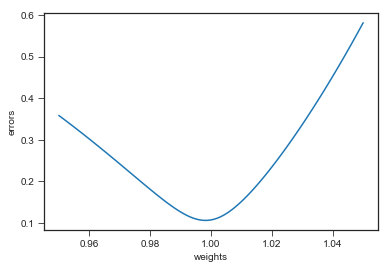

In [61]:
select_weights()

In [62]:
dtest=xgb.DMatrix(test[features])

In [63]:
params = {"objective": "reg:linear", # for linear regression
          "booster" : "gbtree",   # use tree based models 
          "eta": 0.04,   # learning rate
          "max_depth": 10,    # maximum depth of a tree
          "subsample": 0.9,    # Subsample ratio of the training instances
          "colsample_bytree": 0.7,   # Subsample ratio of columns when constructing each tree
          "silent": 1,   # silent mode
          "seed": 13   # Random number seed
          }
num_round = 2500

In [64]:
model = xgb.train(params, dtrain_total, num_round)
preds = model.predict(dtest)

In [47]:
preds

array([ 8.335894,  8.919222,  9.124455, ...,  8.783971, 10.012332,
        8.905322], dtype=float32)

In [48]:
result= np.expm1(preds*0.998)

In [49]:
sub_df=pd.DataFrame({'Id':test.Id,'Sales':result})

In [50]:
sub_df.head()

,Id,Sales
0,1,4100.969238
1,2,7341.123535
2,3,9010.049805
3,4,6922.423828
4,5,6982.057129


In [51]:
sub_df.to_csv('sub_df12.csv',index=None)

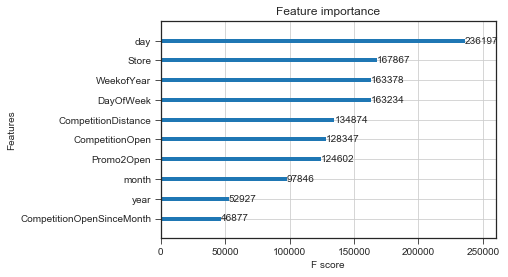

In [52]:
xgb.plot_importance(model,max_num_features= 10)